<style>
.wzor {
  /* width: auto; */
  /* padding: auto; */
  border: 0.5rem solid gray;
  /* margin: 0; */
  background-color: lightgray;
}
</style>


# Modele analizy danych

Tomasz Rodak

---

## Literatura
   1. James, G., Witten, D., Hastie, T., Tibshirani, R., & Taylor,
      J. (2023). An Introduction to Statistical Learning: With
      Applications in Python.
      
      [ISLP](https://www.statlearning.com/)
   
   2. Bishop, C. M., & Nasrabadi, N. M. (2006). Pattern recognition and
      machine learning (Vol. 4, No. 4, p. 738). New York: springer. 
   
      [PRML](https://www.microsoft.com/en-us/research/people/cmbishop/prml-book/)
   
   3. Kroese, D. P., Botev, Z., Taimre, T., & Vaisman, R. (2019). Data
      science and machine learning: mathematical and statistical
      methods. CRC Press.
   
      [https://people.smp.uq.edu.au/DirkKroese/DSML/](https://people.smp.uq.edu.au/DirkKroese/DSML/)
   
   4. Hastie, T., Tibshirani, R., Friedman, J. H., & Friedman,
      J. H. (2009). The elements of statistical learning: data mining,
      inference, and prediction (Vol. 2, pp. 1-758). New York:
      springer.
   
      [https://hastie.su.domains/ElemStatLearn/](https://hastie.su.domains/ElemStatLearn/)
   
   5. Murphy, K. P. (2022). Probabilistic machine learning: an
      introduction. MIT press.
   
      [https://probml.github.io/pml-book/book1.html](https://probml.github.io/pml-book/book1.html)
   
   6. Murphy, K. P. (2023). Probabilistic machine learning: Advanced
      topics. MIT press.
   
      [https://probml.github.io/pml-book/book2.html](https://probml.github.io/pml-book/book2.html)
   
   7. Bishop, C. M., & Bishop, H (2024). Deep learning. Springer.
   
      [https://www.bishopbook.com/](https://www.bishopbook.com/)
   
   8. Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep learning. MIT press.
   
      [https://www.deeplearningbook.org/](https://www.deeplearningbook.org/)

---

## Wykład XIII

ISLP, rozdział 6.1

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme("notebook")

In [2]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [3]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler

## Regularyzacja

### Regresja grzbietowa (*ridge regression*)

Rozważmy klasyczny model liniowy

$$
Y = \beta_0 + \beta_1 X_1 + \ldots + \beta_p X_p + \varepsilon.
$$

Poszukujemy parametrów $\beta_0, \beta_1, \ldots, \beta_p$. Ich estymatory $\hat{\beta}_0, \hat{\beta}_1, \ldots, \hat{\beta}_p$ wyznaczamy na podstawie danych treningowych. Jeśli stosujemy metodę najmniejszych kwadratów, to minimalizujemy względem $\beta_0, \beta_1, \ldots, \beta_p$ funkcję

$$
\text{RSS}(\beta) = \sum_{i=1}^n \left( y_i - \beta_0 - \sum_{j=1}^p \beta_j x_{ij} \right)^2.
$$

Model regresji grzbietowej (*ridge regression*) jest podobny, ale narzuca dodatkowe ograniczenie na parametry $\beta_1, \ldots, \beta_p$. W tym nowym przypadku minimalizujemy względem $\beta_0, \beta_1, \ldots, \beta_p$ funkcję postaci

$$
\text{RSS}(\beta) + \lambda \sum_{j=1}^p \beta_j^2,
$$

gdzie $\lambda \geq 0$ jest ustalonym parametrem. Jeśli $\lambda = 0$, to otrzymujemy klasyczny model liniowy. Jeśli $\lambda > 0$, to otrzymujemy model regresji grzbietowej, w tym przypadku optymalne parametry $\beta_0, \beta_1, \ldots, \beta_p$ będą inne niż w klasycznym modelu liniowym.

**Ważne:** w modelu regresji grzbietowej nie narzuca się ograniczeń na $\beta_0$. 

W przypadku zwykłej regresji liniowej estymatory $\hat{\beta}_1, \ldots, \hat{\beta}_p$ skalują się zgodnie z wartościami predyktorów $X_1, \ldots, X_p$: zamiana $X_j$ na $cX_j$ skutkuje zamianą $\hat{\beta}_j$ na $\hat{\beta}_j/c$. Analogicznej zależności nie ma w modelu regresji grzbietowej i z tego powodu zaleca się w tym przypadku standaryzację predyktorów. 

Standaryzacja polega na przekształceniu zmiennych $X_1, \ldots, X_p$ na zmienne $X_1^*, \ldots, X_p^*$ postaci

\begin{equation*}
X_j^* = \frac{X_j - \bar{X}_j}{s_j},
\end{equation*}

gdzie $\bar{X}_j$ to średnia wartość $j$-tego predyktora, $s_j$ to odchylenie standardowe $j$-tego predyktora:

\begin{equation*}
\bar{X}_j = \frac{1}{n} \sum_{i=1}^n X_{ij},\quad s_j = \sqrt{\frac{1}{n} \sum_{i=1}^n (X_{ij} - \bar{X}_j)^2}.
\end{equation*}

In [4]:
credit = pd.read_csv('datasets/Credit.csv')
credit.head()

,Income,Limit,Rating,Cards,Age,Education,Own,Student,Married,Region,Balance
0,14.891,3606,283,2,34,11,No,No,Yes,South,333
1,106.025,6645,483,3,82,15,Yes,Yes,Yes,West,903
2,104.593,7075,514,4,71,11,No,No,No,West,580
3,148.924,9504,681,3,36,11,Yes,No,No,West,964
4,55.882,4897,357,2,68,16,No,No,Yes,South,331


In [5]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from itertools import combinations

CATEGORICAL = ["Own", "Student", "Married", "Region"]
NUMERICAL = ["Income", "Limit", "Rating", "Cards", "Age", "Education"]

X = credit.drop(columns=["Balance"])

ct = ColumnTransformer(
    transformers=[("ohe", OneHotEncoder(drop="first"), CATEGORICAL)],
    remainder="passthrough",
    verbose_feature_names_out=False
)

X = pd.DataFrame(ct.fit_transform(X), columns=ct.get_feature_names_out())
y = credit["Balance"]

X.head()

,Own_Yes,Student_Yes,Married_Yes,Region_South,Region_West,Income,Limit,Rating,Cards,Age,Education
0,0.0,0.0,1.0,1.0,0.0,14.891,3606.0,283.0,2.0,34.0,11.0
1,1.0,1.0,1.0,0.0,1.0,106.025,6645.0,483.0,3.0,82.0,15.0
2,0.0,0.0,0.0,0.0,1.0,104.593,7075.0,514.0,4.0,71.0,11.0
3,1.0,0.0,0.0,0.0,1.0,148.924,9504.0,681.0,3.0,36.0,11.0
4,0.0,0.0,1.0,1.0,0.0,55.882,4897.0,357.0,2.0,68.0,16.0


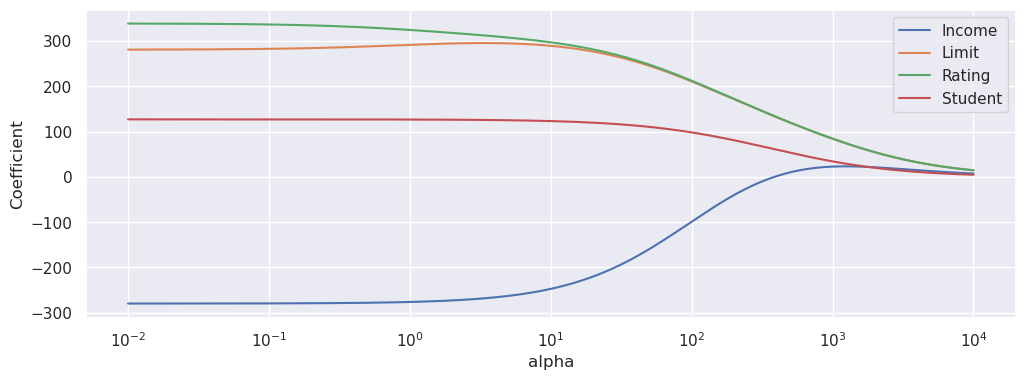

In [6]:
X = credit.loc[:, ['Income', 'Limit', 'Rating']]
X.loc[:, 'Student'] = credit['Student'].map({'Yes': 1, 'No': 0})
y = credit['Balance']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

alphas = np.geomspace(1e-2, 1e4, 500)
params = []

for alpha in alphas:
    reg = Ridge(alpha=alpha).fit(X_scaled, y)
    params.append(reg.coef_.tolist())

params = pd.DataFrame(params, columns=X.columns)
params['alpha'] = alphas

fig, ax = plt.subplots(figsize=(12, 4))
for col in params.columns[:-1]:
    ax.plot(params['alpha'], params[col], label=col)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('Coefficient')
ax.legend();

### Regresja LASSO (*least absolute shrinkage and selection operator*)

Model regresji LASSO jest podobny do regresji grzbietowej, ale zamiast dodawać do funkcji RSS karę w postaci sumy kwadratów parametrów, dodaje się sumę wartości bezwzględnych:

\begin{equation*}
\text{RSS}(\beta) + \lambda \sum_{j=1}^p |\beta_j|.
\end{equation*}

Podoobnie jak wcześniej, $\lambda \geq 0$ jest ustalonym parametrem. Na parametr $\beta_0$ nie nakłada się żadnych ograniczeń.

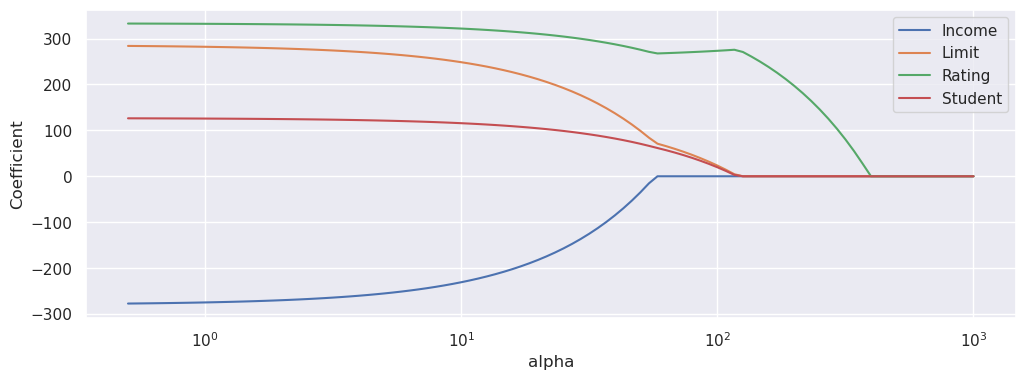

In [7]:
X = credit.loc[:, ['Income', 'Limit', 'Rating']]
X.loc[:, 'Student'] = credit['Student'].map({'Yes': 1, 'No': 0})
y = credit['Balance']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

alphas = np.geomspace(.5, 1e3, 100)
params = []

for alpha in alphas:
    reg = Lasso(alpha=alpha).fit(X_scaled, y)
    params.append(reg.coef_.tolist())
    
params = pd.DataFrame(params, columns=X.columns)
params['alpha'] = alphas

fig, ax = plt.subplots(figsize=(12, 4))
for col in params.columns[:-1]:
    ax.plot(params['alpha'], params[col], label=col)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('Coefficient')
ax.legend();

### Alternatywne definicja regresji Ridge i LASSO

Można pokazać, że regresja grzbietowa jest równoważna minimalizacji $\text{RSS}(\beta)$ przy ograniczeniu $\sum_{j=1}^p \beta_j^2 \leq s$, gdzie $s$ jest ustalonym parametrem:

\begin{equation*}
\operatorname{argmin}_{\beta} \sum_{i=1}^n \left( y_i - \beta_0 - \sum_{j=1}^p \beta_j x_{ij} \right)^2 \quad \text{przy ograniczeniu} \quad \sum_{j=1}^p \beta_j^2 \leq s.
\end{equation*}

Dokładniej, oznacza to, że regresja grzbietowa z ustalonym $\lambda$ jest równoważna zdefiniowanej powyżej minimalizacji przy pewnym $s$ i odwrotnie.

Podobnie, regresja LASSO jest równoważna minimalizacji $\text{RSS}(\beta)$ przy ograniczeniu $\sum_{j=1}^p |\beta_j| \leq s$:

\begin{equation*}
\operatorname{argmin}_{\beta} \sum_{i=1}^n \left( y_i - \beta_0 - \sum_{j=1}^p \beta_j x_{ij} \right)^2 \quad \text{przy ograniczeniu} \quad \sum_{j=1}^p |\beta_j| \leq s.
\end{equation*}

Ujęcie to ma ciekawą konsekwencję. Parametr $s$ możemy traktować jako *budżet* przeznaczony na parametry modelu. Jeśli parametry $\hat{\beta}_1, \ldots, \hat{\beta}_p$ nie przekraczają budżetu $s$, tzn. $\sum_{j=1}^p \hat{\beta}_j^2 \leq s$ w przypadku regresji grzbietowej lub $\sum_{j=1}^p |\hat{\beta}_j| \leq s$ w przypadku regresji LASSO, to otrzymujemy model taki sam jak w klasycznym przypadku liniowym. W przeciwnym razie otrzymujemy model o parametrach $\hat{\beta}_1, \ldots, \hat{\beta}_p$ dających punkt na granicy budżetu $s$: $\sum_{j=1}^p \hat{\beta}_j^2 = s$ w przypadku regresji grzbietowej lub $\sum_{j=1}^p |\hat{\beta}_j| = s$ w przypadku regresji LASSO. Będzie to ten punkt, w którym hiperpowierzchnia stałego RSS dotyka w jednym punkcie hiperpowierzchnię ograniczeń. Ponieważ dla regresji LASSO hiperpowierzchnia ograniczeń ma kształt hiperoktaedru (kula w normie $L_1$), więc punkt ten na ogół leży na jednej z niżej wymiarowych ścian. Ściany te jednak są zawarte w podukładach osi układu współrzędnych, więc punkt ten jest na ogół rzadki, tzn. ma wiele zerowych współrzędnych.

<div class="wzor">

**Wniosek:** regresja LASSO ma wbudowany mechanizm selekcji predyktorów. 

</div>